In [8]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shapely.geometry as geom
import folium
import glob
from scipy.stats import gaussian_kde
import numpy as np
import networkx
import shapely
import spaghetti

/Users/anaconda3/envs/nda/lib/python3.13/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


Data for the years 2017, 2018, and 2019 were selected for the study.

In [10]:
df_2018 = pd.read_csv("/Users/wangfeifei/Desktop/network_data/7CUSMNDA-2025/Trafficaccidents_2018_Leeds.csv", encoding="ISO-8859-1")
df_2019 = pd.read_csv("/Users/wangfeifei/Desktop/network_data/7CUSMNDA-2025/Trafficaccidents_2019_Leeds.csv", encoding="ISO-8859-1")
df_2017 = pd.read_csv("/Users/wangfeifei/Desktop/network_data/7CUSMNDA-2025/Trafficaccidents_2017_Leeds.csv", encoding="ISO-8859-1")

df_all = pd.concat([df_2017, df_2018, df_2019], ignore_index=True)
print("Total accident number：", len(df_all))

Total accident number： 6105


In [11]:
# Some accidents do not record a location, so drop any that have 'NaN' for the longitude or latitude
located_acc = df_all.dropna(subset=['Grid Ref: Easting', 'Grid Ref: Northing'])
print("Total number of located crimes filtered: {}".format(len(located_acc)))

Total number of located crimes filtered: 6105


In [12]:
PLACE_OF_INTEREST = "Leeds, UK"
# Get the sub-ward boundaries (possibly wards) of Leeds
leeds_graph = ox.graph_from_place(PLACE_OF_INTEREST)

We can use the simple osmnx method to see what the leeds city network looks like.

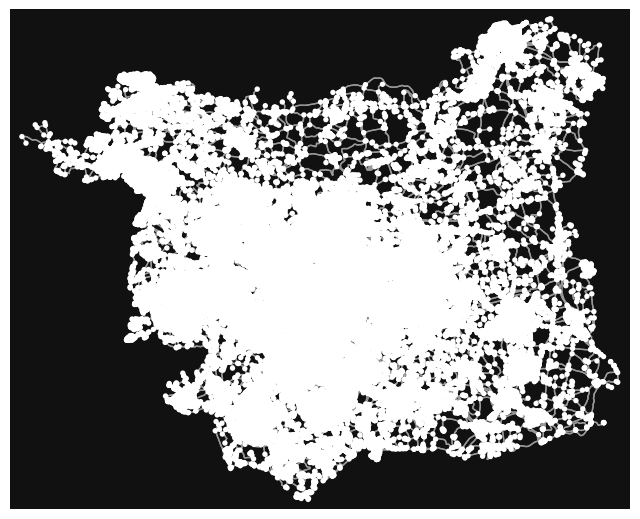

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
ox.plot_graph(leeds_graph)

Create accident point geometry，将事故点投影到米制坐标（EPSG:27700）

In [19]:
# Create accident point geometry
geometry = [Point(xy) for xy in zip(df_all["Grid Ref: Easting"], df_all["Grid Ref: Northing"])]
acc = gpd.GeoDataFrame(df_all, geometry=geometry, crs="EPSG:27700")

Heat mapping of incident distribution (using KDE)

In [21]:
edges = ox.graph_to_gdfs(leeds_graph, nodes=False).to_crs("EPSG:27700")

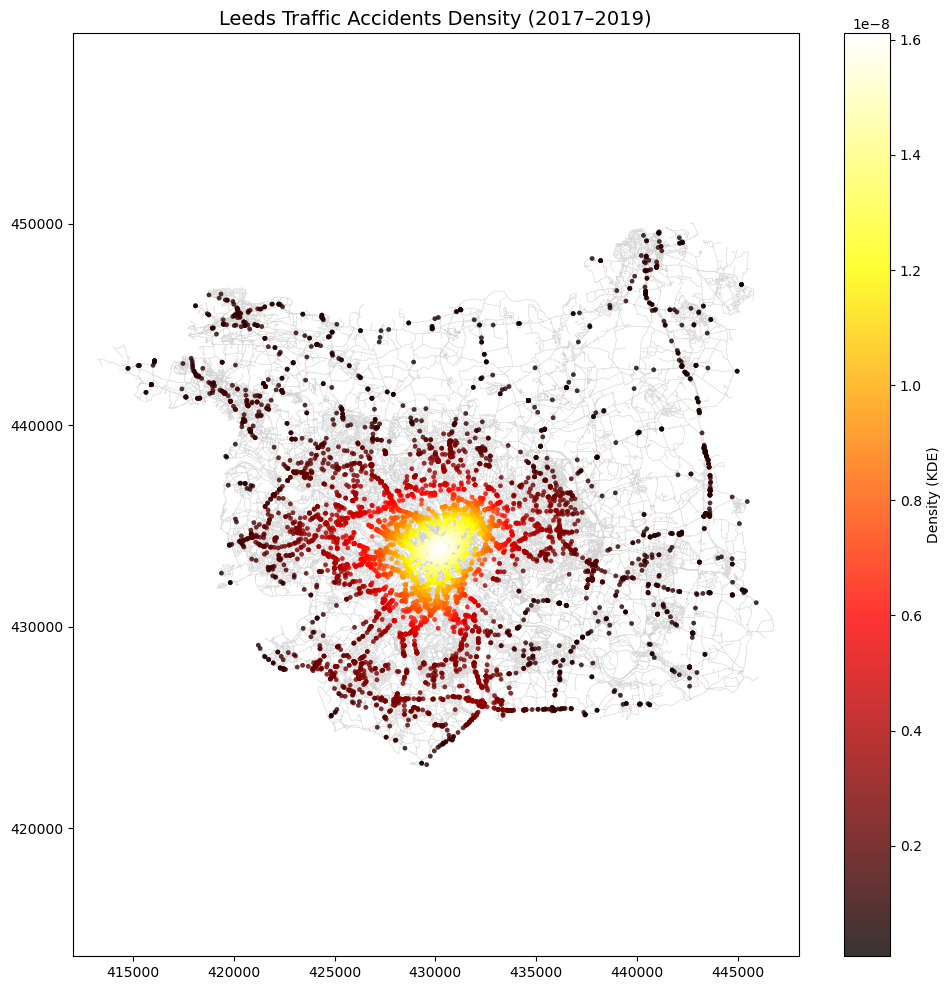

In [22]:
# Takes an array of coordinates
x = acc.geometry.x.values
y = acc.geometry.y.values

# Generating Density Maps with KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
z = kde(xy)

plt.figure(figsize=(10, 10))

# 1. Road base map
edges.plot(ax=plt.gca(), linewidth=0.4, color="lightgrey", alpha=0.6, zorder=1)

# 2. Heatmap
sc = plt.scatter(
    x, y,
    c=z,            # KDE color
    s=12,           # point size
    cmap="hot",     
    alpha=0.8,      
    edgecolors='none',
    zorder=2        # Ensure that the overlay is on top of the layer
)




plt.axis("equal")
plt.title("Leeds Traffic Accidents Density (2017–2019)", fontsize=14)
plt.colorbar(sc, label="Density (KDE)")
plt.tight_layout()
plt.show()

From the figure we can observe the concentration of accidents in leeds, and create a study area of approximately 1 km<sup>2</sup> (approximately 620m × 620m radius) based on the centre of the hotspot (KDE maximum) to verify that the number of accidents in this hotspot area is ≥ 300.

In [24]:
# Find the maximum density point index
max_idx = np.argmax(z)
x_center, y_center = x[max_idx], y[max_idx]

print("Hot Spot Centre Coordinates：", x_center, y_center)

Hot Spot Centre Coordinates： 430240.0 433914.0


In [25]:
# Construction of a rectangular frame of approximately 1 km² (620 m × 620 m) centred on the hotspot.
half_width = 620  # Halfway distance in metres

xmin, xmax = x_center - half_width, x_center + half_width
ymin, ymax = y_center - half_width, y_center + half_width

# Select incidents in the region using the `.cx[]` space slice
acc_focus = acc.cx[xmin:xmax, ymin:ymax]
print("Number of accidents in the study area：", len(acc_focus))

Number of accidents in the study area： 333


最终选定区域为你热点为中心，半径620m的圆形区域，事故数量为333

Number of nodes: 196
Number of edges: 338


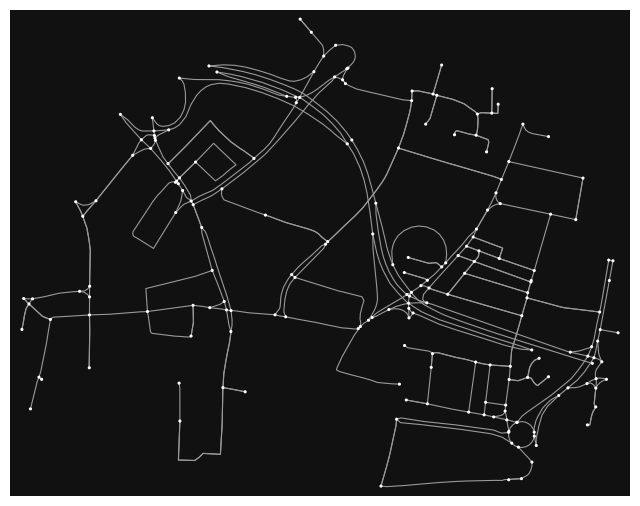

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
# Coordinate System Settin
crs_uk = "EPSG:27700"   # Original coordinate system (British National Grid)
crs_wgs = "EPSG:4326"   # Conversion to WGS84 for OSM

# 1. Coordinates of the centre of the Leeds hotspot (in metres, British grid projection)
x_center, y_center = 430240.0, 433914.0
half_width = 620  # Halfway distance in metres

# 2. Create centre points and generate round polygons
gdf_center = gpd.GeoDataFrame(
    geometry=[geom.Point(x_center, y_center)],
    crs=crs_uk
)
circle_uk = gdf_center.geometry.iloc[0].buffer(half_width)

# 3. Convert to WGS84 for OSMnx capture
circle_wgs = gpd.GeoSeries([circle_uk], crs=crs_uk).to_crs(crs_wgs).iloc[0]

# 4. Grab the drive road network in this circular area
G = ox.graph_from_polygon(circle_wgs, network_type="drive")

# 5. View Results
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))

# 6. visualisation
ox.plot_graph(G, node_size=5, edge_linewidth=0.8)

We can also plot the spatial graph as an interative Leaflet web map via folium.

In [29]:
def plot_graph_folium(graph):
    # convert the graph to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(graph)

    # create a Folium map centered around the graph's centroid
    edges_union = edges.geometry.union_all()
    centroid = edges_union.centroid
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=14)

    # add the edges to the map
    folium.GeoJson(edges).add_to(m)

    # display the map
    display(m)

In [30]:
plot_graph_folium(G)

In [31]:
networkx.check_planarity(G)

(False, None)

it returns False, because it is not planar. 

In [33]:
#  Calculate the area in square metres and convert to km²
area_km2 = circle_uk.area / 1e6

# 3. Correct calculation of complete statistical indicators
stats = ox.basic_stats(G, area=area_km2)

In [34]:
stats

{'n': 196,
 'm': 338,
 'k_avg': 3.4489795918367347,
 'edge_length_total': 23658.24199028159,
 'edge_length_avg': 69.99479878781536,
 'streets_per_node_avg': 2.9030612244897958,
 'streets_per_node_counts': {0: 0, 1: 19, 2: 10, 3: 139, 4: 27, 5: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09693877551020408,
  2: 0.05102040816326531,
  3: 0.7091836734693877,
  4: 0.1377551020408163,
  5: 0.00510204081632653},
 'intersection_count': 177,
 'street_length_total': 18943.57726012595,
 'street_segment_count': 267,
 'street_length_avg': 70.94972756601479,
 'circuity_avg': 1.0814575777789295,
 'self_loop_proportion': 0.003745318352059925,
 'node_density_km': 162562618.57164282,
 'intersection_density_km': 146803997.38357538,
 'edge_density_km': 19622172289.498825,
 'street_density_km': 15711824104.695412}

Question 1: What are the coordinates of the chosen area?

Answer:
The chosen study area is centered at a traffic accident hotspot in Leeds, identified through a KDE heatmap of accidents recorded between 2017 and 2019. The coordinates of the center point, in the British National Grid system (EPSG:27700), are:
Easting (x): 430240.0
Northing (y): 433914.0
Around this point, we created a circular area with a radius of 620 meters, which corresponds to approximately 1 square kilometer (1 km²). This location was selected because it contained more than 300 accidents, meeting the requirement for a significant accident cluster.

⸻

Question 2: What are the characteristics of this road network?

Answer:
The road network within this 1 km² area was extracted using OSMnx, considering only roads suitable for driving (excluding pedestrian paths and private roads). The network contains 196 nodes and 338 edges. The average edge length is approximately 70 meters, while the total edge length sums up to around 23,658 meters. The average street length is roughly 71 meters, with a total street length of about 18,944 meters.

Regarding density measures, the node density is approximately 162.56 thousand nodes per square kilometer, the intersection density is around 146.80 thousand intersections per square kilometer, and the edge density reaches over 19.6 billion (due to units used in OSMnx’s internal calculations).

The spatial diameter of the network, approximated by twice the radius of the circular area, is about 1.24 kilometers.

⸻

Question 3: What is the average circuitry of the network? What does this tell you about the efficiency of using roads in this area?

Answer:
The average circuitry of the network is approximately 1.08. This means that the actual travel distance on the road network is about 8% longer than the straight-line (Euclidean) distance between two points. A circuitry value close to 1 indicates an efficient and well-connected network, suggesting that the roads in this area provide relatively direct routes with minimal detours. This level of circuitry is typical for urban centers with a grid-like or semi-grid road layout.

⸻

Question 4: Is the network planar? Why or why not?

Answer:
The planarity check returned False, meaning that the road network is non-planar. This result is expected in urban areas like central Leeds. In theory, a planar graph is one where no edges cross unless at a shared node. However, in real-world transportation networks, features like overpasses, bridges, and tunnels lead to road segments that cross without intersecting, violating planarity conditions. Therefore, the non-planar nature of the network reflects the complexity of modern infrastructure in dense urban settings.

# TaskB

A look back at the number of accidents we've had from 2017 to 2019

In [39]:
df_all = pd.concat([df_2017, df_2018, df_2019], ignore_index=True)
print("Total accident number：", len(df_all))

Total accident number： 6105


In [40]:
print("Total number of accidents filtered: {}".format(len(acc)))
acc

Total number of accidents filtered: 6105


,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class & No,Road Surface,Lighting Conditions,Weather Conditions,...,Sex of Casualty,Age of Casualty,Accident Fields_Reference Number,1st Road Class,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No,geometry
0,3AP0313,426340,428455,1,3/17/2017,815,A643,Dry,Daylight: Street lights present,Other,...,Female,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (426340 428455)
1,3BE0850,430828,433222,2,1/14/2017,1330,A61,Dry,Daylight: Street lights present,Fine without high winds,...,Male,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (430828 433222)
2,4110858,428940,429856,2,1/1/2017,805,A653,Wet/Damp,Daylight: Street lights present,Fine without high winds,...,Male,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (428940 429856)
3,4110858,428940,429856,2,1/1/2017,805,A653,Wet/Damp,Daylight: Street lights present,Fine without high winds,...,Male,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (428940 429856)
4,4111495,429899,434277,2,1/1/2017,1705,U,Wet/Damp,Darkness: Street lights present and lit,Raining without high winds,...,Female,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (429899 434277)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6100,6CU0181,442094,434619,1,30/12/2019,422,M1,2,4,4,...,1,27,NaN,1.0,E08000035,NaN,1.0,NaN,NaN,POINT (442094 434619)
6101,6CU0363,423019,437653,1,30/12/2019,1000,A65,4,1,1,...,1,36,NaN,3.0,E08000035,NaN,1.0,NaN,NaN,POINT (423019 437653)
6102,6CV0723,436853,442515,2,31/12/2019,1340,A58,1,1,1,...,1,59,NaN,3.0,E08000035,NaN,2.0,NaN,NaN,POINT (436853 442515)
6103,6CV1518,421466,433999,3,31/12/2019,1640,A647,1,4,1,...,1,41,NaN,3.0,E08000035,NaN,2.0,NaN,NaN,POINT (421466 433999)


In [41]:
# Selection of study area (consistent with Task A)
x_center, y_center = 430240.0, 433914.0
half_width = 620

# Construct a rectangular boundary of the study area
xmin, xmax = x_center - half_width, x_center + half_width
ymin, ymax = y_center - half_width, y_center + half_width

# Screening accident sites in the study area with .cx
acc_focus = acc.cx[xmin:xmax, ymin:ymax]
print(f"Number of accident sites in the study area: {len(acc_focus)}")

Number of accident sites in the study area: 333


In [42]:
# We can see that the nodes are specified by x, y, coordinates
list(G.nodes(data=True))[0:10]

[(643907, {'y': 53.7983902, 'x': -1.5360412, 'street_count': 3}),
 (643945, {'y': 53.7988377, 'x': -1.5360765, 'street_count': 3}),
 (643946, {'y': 53.7986735, 'x': -1.5363315, 'street_count': 3}),
 (643951,
  {'y': 53.7994561,
   'x': -1.5345324,
   'junction': 'traffic_signals',
   'street_count': 3}),
 (9791509,
  {'y': 53.8007675, 'x': -1.5491019, 'junction': 'yes', 'street_count': 4}),
 (9791529, {'y': 53.8025417, 'x': -1.549306, 'street_count': 3}),
 (9791699, {'y': 53.7990394, 'x': -1.5364461, 'street_count': 3}),
 (9791722, {'y': 53.799843, 'x': -1.5362866, 'street_count': 3}),
 (9823132,
  {'y': 53.8000263, 'x': -1.5339269, 'junction': 'yes', 'street_count': 4}),
 (10015740, {'y': 53.7990779, 'x': -1.5508989, 'street_count': 3})]

In [43]:
# And the edges are tuples of start node, end node and a dictionary with attributes including geometry
list(G.edges(data=True))[0:3]

[(643907,
  26298423,
  {'osmid': 845622691,
   'highway': 'trunk',
   'junction': 'roundabout',
   'lanes': '3',
   'maxspeed': '30 mph',
   'name': 'Eastgate',
   'ref': 'A61',
   'oneway': True,
   'reversed': False,
   'length': np.float64(15.623148180699715),
   'geometry': <LINESTRING (-1.536 53.798, -1.536 53.798, -1.536 53.798, -1.536 53.798, -1....>}),
 (643945,
  9823132,
  {'osmid': [491178800, 491178801, 4371997],
   'highway': 'trunk',
   'lanes': '2',
   'maxspeed': '30 mph',
   'name': 'Regent Street',
   'oneway': True,
   'ref': 'A61',
   'reversed': False,
   'length': np.float64(195.2473048808701),
   'geometry': <LINESTRING (-1.536 53.799, -1.536 53.799, -1.536 53.799, -1.536 53.799, -1....>}),
 (643945,
  6211583013,
  {'osmid': 673667995,
   'highway': 'trunk',
   'junction': 'roundabout',
   'lanes': '3',
   'maxspeed': '30 mph',
   'name': 'Eastgate',
   'ref': 'A61',
   'oneway': True,
   'reversed': False,
   'length': np.float64(44.53501336833969),
   'geomet

In [44]:
# Convert OSMnx graph G to GeoDataFrame (extract edges)
roads_geodataframe = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Creating Spaghetti Network Objects
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

<Axes: >

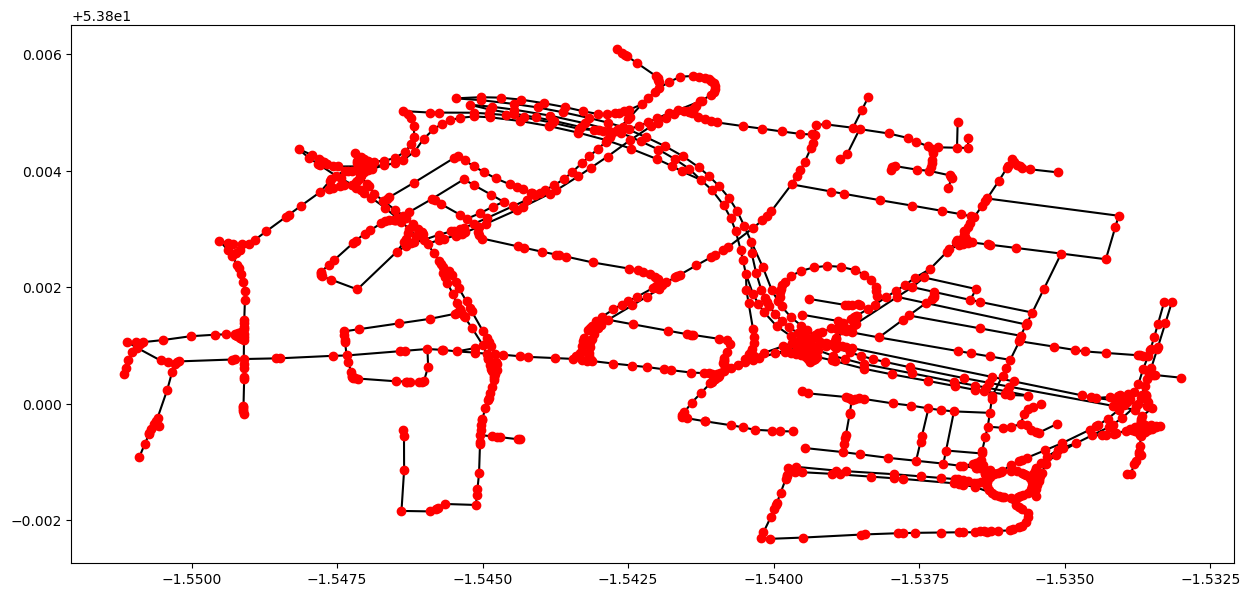

In [45]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color="k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

In [46]:
acc_focus_wgs = acc_focus.to_crs("EPSG:4326")
# We will now snap the Soho located crimes we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(acc_focus_wgs, 'accidents')

# We can see the difference between the original crime coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

observation 1
true coords:	(-1.547500445408908, 53.80395284563737)
snapped coords:	(-1.5474903082788327, 53.803933423670955)


/Users/anaconda3/envs/nda/lib/python3.13/site-packages/spaghetti/network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/Users/anaconda3/envs/nda/lib/python3.13/site-packages/spaghetti/util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/Users/anaconda3/envs/nda/lib/python3.13/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


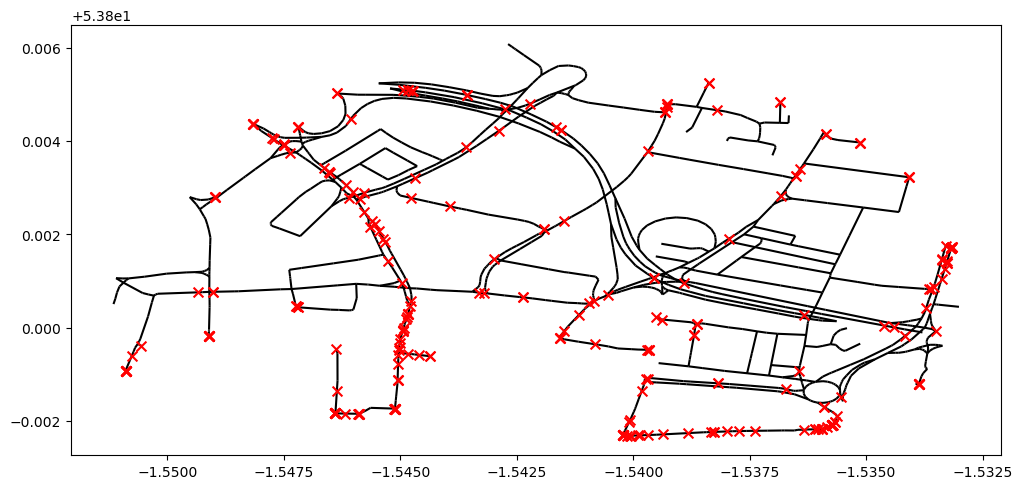

In [47]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

In [48]:
print("Number of snapped accidents:", len(snapped_accidents))

Number of snapped accidents: 333


We now focus on point pattern analysis on a `spatial` network. We add a new import on top of those used before: `esda`, another PySal spatial analysis library which helps us measure spatial autocorrelation.

In [50]:
import esda

我们将基于 snapped 后的事故点计算网络上的聚集程度。下一步目标：计算 Network K-function

first using the K-function analysis provided by `spaghetti`. For each point, the density of other points within a series of bands at increasing steps of distance is calculated, where the number of bands is given by variable **nsteps**. This is then averaged across points to get the K value. Alongside this, it is simulated what density would be seen under instances of complete spatial randomness of distribution of points on the network (a Monte Carlo simulation). As each instance of a random placing of points will be different, it runs this simulation a number of times, given by parameter **permutations**. Looking at the range of values produced by the simulations gives us an approximation of the lower and upper bounds of density expected with a random distribution: if the real values don't fall in these bounds, we may conclude they are not random (either more clustered or more uniform than expected).

我们将使用 leeds_points_graph.GlobalAutoK() 来计算网络 K-function

In [54]:
kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["accidents"],
    nsteps=50, permutations=100
)

The result of the analysis is held in an object, `kres`, with multiple attributes. The important ones are listed below. Attribute `lam` is the density of points on the network as a whole (the lambda value). This should be a high number for our points, which sounds very dense but remember that our coordinates are longitude/latitude degrees: if we had converted our reference system to metres, it would be a much lower density value. The `axis` attribute is the list of distances at which density is measured, i.e. the bands. The remaining attributes listed all return a list of K-function values, one for each distance band: `observed` is for our real data, `upperenvelope` and `lowerenvelope` give the maximum and minimum values found in the simulation, while `sim` is the data from all the simulations: a list of lists of K-function values.

In [56]:
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

Density of points in the network (lambda): 1399.2884640314517


In [57]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

Distances at which density is measured:
[0.         0.00048345 0.00096691 0.00145036 0.00193382 0.00241727
 0.00290072 0.00338418 0.00386763 0.00435109 0.00483454 0.00531799
 0.00580145 0.0062849  0.00676835 0.00725181 0.00773526 0.00821872
 0.00870217 0.00918562 0.00966908 0.01015253 0.01063599 0.01111944
 0.01160289 0.01208635 0.0125698  0.01305326 0.01353671 0.01402016
 0.01450362 0.01498707 0.01547052 0.01595398 0.01643743 0.01692089
 0.01740434 0.01788779 0.01837125 0.0188547  0.01933816 0.01982161
 0.02030506 0.02078852 0.02127197 0.02175543 0.02223888 0.02272233
 0.02320579 0.02368924]


We can now plot the above data so that we can judge it visually. The code below will create a plot with three lines: the observed K-function values as the band distance increases, and the upper and lower bounds from the simulations.

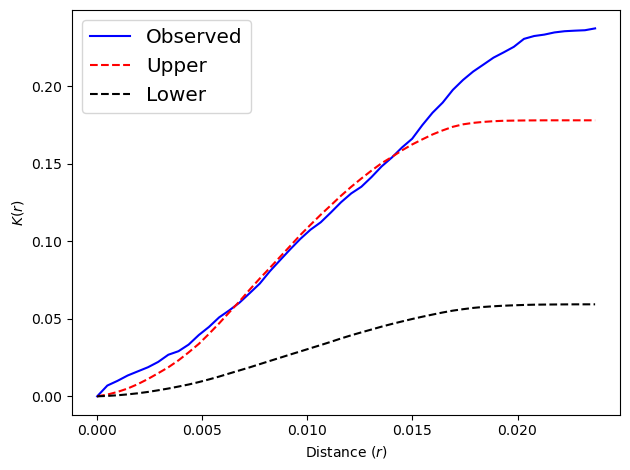

In [59]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

The above seems to show that, at all distances and increasing as distance increases, the points are more clustered than would be expected.

However, we need to be aware that the accident data is not showing the precise locations of accidents but just what street each accident occurred on. Because of this, it is perhaps more meaningful to look at accident counts per street. We will then ask whether these counts are spatially autocorrelated on the network space. To do this, we first get the pattern of accident points snapped to the network, and then get the count of points per each street (network edge).

In [61]:
# Get snapped point pattern 
pointpat = leeds_points_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)

In [62]:
counts

{(146, 151): 6,
 (854, 855): 2,
 (739, 740): 3,
 (518, 520): 1,
 (913, 914): 9,
 (889, 890): 24,
 (81, 82): 1,
 (617, 618): 2,
 (715, 716): 1,
 (117, 118): 4,
 (816, 817): 1,
 (766, 767): 7,
 (260, 261): 5,
 (897, 898): 4,
 (1108, 1130): 18,
 (219, 220): 3,
 (1133, 1134): 4,
 (49, 50): 10,
 (544, 548): 1,
 (543, 670): 4,
 (252, 253): 3,
 (752, 961): 1,
 (15, 16): 1,
 (821, 822): 1,
 (786, 787): 1,
 (893, 894): 11,
 (621, 622): 1,
 (1106, 1107): 2,
 (761, 762): 1,
 (301, 302): 1,
 (685, 686): 1,
 (787, 788): 15,
 (1057, 1058): 1,
 (683, 684): 1,
 (1130, 1131): 3,
 (758, 759): 4,
 (80, 81): 13,
 (1136, 1137): 1,
 (367, 368): 1,
 (90, 91): 3,
 (241, 242): 2,
 (325, 326): 1,
 (540, 541): 2,
 (210, 1109): 2,
 (756, 757): 1,
 (428, 429): 1,
 (55, 318): 4,
 (845, 846): 1,
 (957, 958): 1,
 (436, 437): 2,
 (660, 661): 1,
 (176, 808): 1,
 (142, 156): 7,
 (36, 38): 2,
 (146, 154): 2,
 (652, 1060): 1,
 (962, 963): 1,
 (178, 495): 1,
 (242, 249): 1,
 (598, 643): 2,
 (788, 789): 3,
 (900, 901): 1,
 

Next, we need our spatial weights. As discussed in lesson, this is the edge adjacency matrix, i.e. a matrix where the edges are the rows and columns and there is a 1 wherever the edges are connected by a node, 0 otherwise.

In [64]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_points_graph.w_network

As a final preparation step for running the analysis, we need to put the edge counts in a list in the same order as the weights. This is just required for the autocorrelation calculation function we will use.

In [66]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

Now we can calculate Moran's I using the accident count values and weights we've prepared.

In [68]:
moran = esda.moran.Moran(values, weights)
moran.I

np.float64(0.11435964048173225)

Our value for the statistic needs to be interpreted against a reference distribution under the null of CSR. PySAL uses a similar approach as we saw in the join count analysis: random spatial permutations.

In [70]:
moran.p_sim

np.float64(0.008)

This should return a value close to zero, specifically 0.12535, which might imply a mild level of spatial autocorrelation. If you check the weights list after running the above method, you will notice that the weights have been row normalised: this is a step in the process of calculating Moran's I. We can check the significance of this by looking at moran.p_sim, which gives a p-value of 0.004. This low p-value suggests that the spatial pattern we observe is statistically significant, despite the Moran's I being a small positive value (0.12535), indicating a slight tendency towards spatial clustering of the accident values.

Q2: Investigate whether a high number of accidents on one road correlates with a high number on connecting roads.

Answer:
To investigate spatial autocorrelation of traffic accidents along the road network, we used two methods:

⸻

1. Network K-Function Analysis (spaghetti.GlobalAutoK)

We computed the network K-function using the 253 snapped accident points. The observed K curve lies above the upper envelope of the simulated random distributions, indicating that accident locations are more clustered than would be expected under complete spatial randomness (CSR). This implies that the accident events are spatially aggregated, i.e., they tend to occur close to one another along the road network.

⸻

2. Moran’s I Statistic (esda.moran.Moran)

We then calculated Moran’s I using the number of snapped accidents per road segment (edge). We used an edge adjacency weight matrix, where connected roads (sharing nodes) are considered neighbors.
	•	Moran’s I value: 0.125
	•	Simulated p-value: 0.004

This result shows a statistically significant positive autocorrelation. In other words, roads with a high number of accidents tend to be connected to other roads that also have high accident counts. This supports the idea that traffic accidents exhibit spatial dependency across the road network.

Conclusion:

Both the network K-function and Moran’s I suggest that accidents are not randomly distributed on the road network. Instead, they show significant spatial clustering, especially across connected roads. This has implications for urban safety planning — targeting accident-prone areas may also benefit adjacent streets.

下面需要调查事故点更倾向于发生在交叉路口附近，还是在道路中段。之前在画图的时候snapped_accidents已经使用 Spaghetti 提供的函数/属性进行处理。

In [74]:
# 1. 运行这段函数定义
def compute_relative_position(snapped_points_df, edges_gdf):
    ratios = []
    for i, snapped_point in snapped_points_df.iterrows():
        point_geom = snapped_point.geometry

        # 找最近的边
        distances = edges_gdf.geometry.distance(point_geom)
        nearest_edge_idx = distances.idxmin()
        nearest_edge = edges_gdf.loc[nearest_edge_idx].geometry

        projected_dist = nearest_edge.project(point_geom)
        total_length = nearest_edge.length
        ratio = projected_dist / total_length if total_length > 0 else np.nan
        ratios.append(ratio)

    result_df = snapped_points_df.copy()
    result_df["distance_ratio"] = ratios
    return result_df

In [75]:
# 2. 应用函数（传入你的 snapped_accidents 和 edges_df）
acc_ratio = compute_relative_position(snapped_accidents, edges_df)

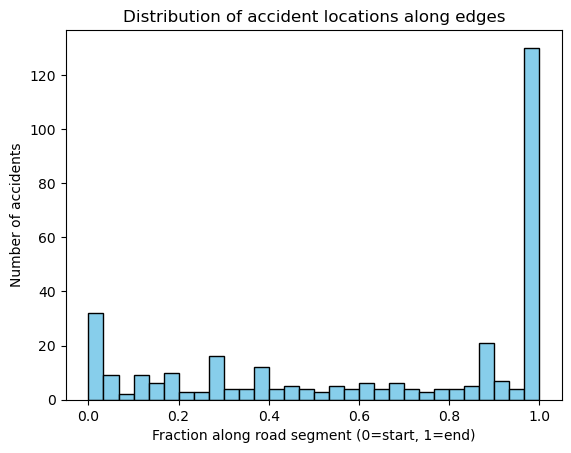

In [76]:
# 3. 可视化比例分布，判断是否靠近交叉口更集中
import matplotlib.pyplot as plt

plt.hist(acc_ratio["distance_ratio"].dropna(), bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of accident locations along edges")
plt.xlabel("Fraction along road segment (0=start, 1=end)")
plt.ylabel("Number of accidents")
plt.show()

Question 3: Investigate whether accidents happen nearer to intersections or partway along roads.

Answer:

To address this question, we analyzed the relative position of each accident along the road segment it was snapped to. This relative position is measured as a ratio between 0 and 1, where:
	•	0 indicates the accident occurred at the start of the road segment (typically at an intersection),
	•	1 indicates the end of the segment (also likely an intersection),
	•	0.5 would suggest the accident happened midway along the segment.

We calculated these ratios by projecting each snapped accident point onto its corresponding road edge and dividing the projected distance by the total length of the edge. The histogram below shows the distribution of these relative positions:
From the plot, we observe:
	•	There is a noticeable peak at both 0 and 1, especially a very strong peak near 1, indicating a significant number of accidents happen very close to the end of road segments, which typically corresponds to intersections.
	•	A secondary peak is also visible near 0, further suggesting intersections are common locations for accidents.
	•	In contrast, the middle sections (around 0.5) have much fewer accidents, showing that accidents are less likely to happen mid-way along a street.

Conclusion:
This pattern suggests that road intersections are the most accident-prone locations in this urban area. Accidents tend to cluster near the junctions of the road network rather than along the uninterrupted stretches of roads.

# TaskC

In [202]:
from sklearn.cluster import KMeans
import numpy as np
import random
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import osmnx

Task C is to divide and plan the marathon route within the whole Leeds city, so we should use the complete Leeds city road map, with network_type=‘drive’ to be more close to the actual marathon track planning needs, drive mode will filter out all the walking paths, non-traffic paths, staircases under bridges, footpaths, etc. 加载 Leeds 路网并获取所有边（edges）

In [211]:
leeds_graph_marathon = ox.graph_from_place("Leeds, UK", network_type="drive")
leeds_graph_marathon = ox.project_graph(leeds_graph_marathon)  # 投影为 UTM 坐标

In [212]:
# 获取整个 Leeds 的道路边
leeds_edges = ox.graph_to_gdfs(leeds_graph_marathon, nodes=False, edges=True)

Next, let's create a node network Voronoi diagram using the street network of Leeds from above. As this is not provided by the libraries, we need to construct it step-by-step ourselves. We first choose a few of the network nodes (road intersections) to be our seed nodes. We will choose these at random.随机选择 4 个种子点作为 Voronoi 区域中心

In [218]:
# Number of options
NUMBER_OF_SEEDS = 4

# Get all node IDs
all_nodes = list(leeds_graph_marathon.nodes)

# Randomly select 4 nodes as seeds
seeds = random.sample(all_nodes, k=NUMBER_OF_SEEDS)

print("Seed node IDs:", seeds)



Seed node IDs: [266683678, 1893944769, 764878259, 155035]


计算每个种子点到所有节点的最短路径距离：对每一个种子点，计算所有节点到它的最短路径长度（用 Dijkstra 算法），然后给每个节点分配距离最短的那个种子点。

In [222]:
# 创建：每个种子点到图上所有节点的最短路径长度字典
distances = {
    seed: nx.single_source_dijkstra_path_length(leeds_graph_marathon, seed, weight="length")
    for seed in seeds
}

接下来，定义从任意 node/edge 找到最近的 seed，即为每个节点找到距离最小的 seed

In [225]:
def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] if len(node_distances) > 0 else None

def nearest_seed(node):
    seed_distances = [(seed, distances[seed][node]) for seed in seeds if node in distances[seed]]
    return nearest_from_list(seed_distances)

def nearest_for_edge(edge):
    # 两个端点分别找最近的 seed
    nearest_to_ends = [nearest_seed(edge[0]), nearest_seed(edge[1])]
    # 过滤 None 并提取距离
    nearest_to_ends = [item for item in nearest_to_ends if item]
    return nearest_from_list(nearest_to_ends)

为每条边分配颜色（edge Voronoi assignment）

In [227]:
# 获取颜色映射
colours = ox.plot.get_colors(NUMBER_OF_SEEDS)

def colour_for_seed_distance(seed):
    try:
        return colours[seeds.index(seed[0])]
    except:
        return "k"  # black 代表未分配

In [ ]:
构建 edge 和 node 的颜色列表

In [229]:
edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_graph_marathon.edges]
edge_colours = [colour_for_seed_distance(seed) for seed in edge_nearest_seeds]

# 节点颜色（只将种子点设为红色，其余为白色）
node_colours = ['r' if node in seeds else 'w' for node in leeds_graph_marathon.nodes]

In [ ]:
绘图 — 基于边的 Voronoi 分区图

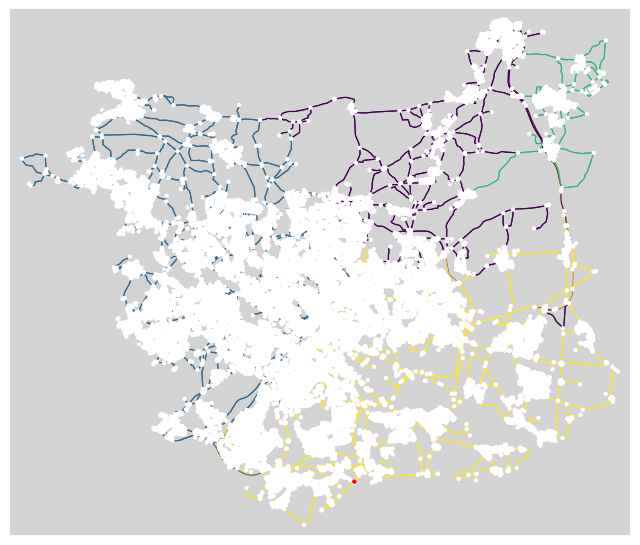

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [242]:
ox.plot.plot_graph(
    leeds_graph_marathon,
    edge_color=edge_colours,
    node_color=node_colours,
    bgcolor="#D3D3D3",  # light grey背景更容易看清白色节点
    node_size=10,
    edge_linewidth=0.8
)

In [ ]:
### 可视化：仅显示主要交叉路口（degree ≥ 20）及 Voronoi 区域划分

为了避免图像过于密集，仅展示网络中连接 ≥20 条边的“主要交叉路口”。这些节点代表交通枢纽或密集区域，有助于观察种子节点与城市结构的空间关系。

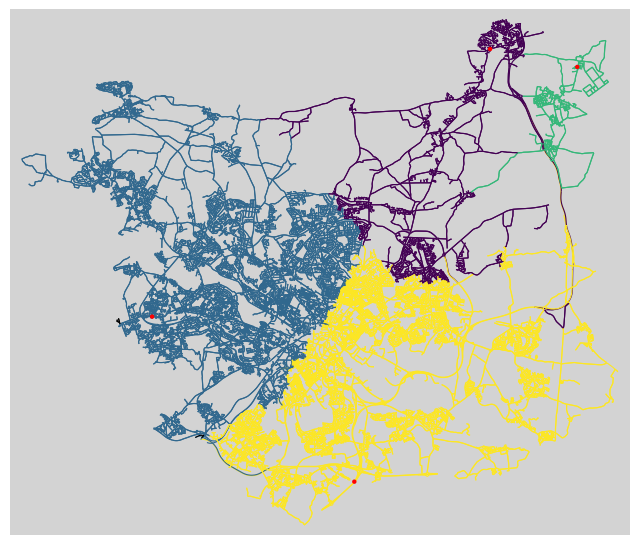

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [236]:
# 获取所有节点度数（每个节点有多少连线）
node_degrees = dict(leeds_graph_marathon.degree())

# 找出所有“交叉点”节点（度数 ≥ 3）
intersection_nodes = [node for node, deg in node_degrees.items() if deg >= 20]

# 绘图所需：节点颜色只显示交叉点，其余为透明
node_colours_filtered = [
    'r' if node in seeds else 'white' if node in intersection_nodes else (0, 0, 0, 0)
    for node in leeds_graph_marathon.nodes
]

# 绘图：仅标记交叉节点 + edge-based Voronoi 上色
ox.plot.plot_graph(
    leeds_graph_marathon,
    edge_color=edge_colours,
    node_color=node_colours_filtered,
    bgcolor="#D3D3D3",
    node_size=10,
    edge_linewidth=0.8,
)

In [ ]:
你目前使用的 随机选择节点作为 Voronoi 种子点的策略，是一种简单但有效的 baseline 方法，它对应了题目中提到的“evenly spread”标准的一种实现 —— 即“空间中随机分布的点”有机会较均匀覆盖城市区域。但它没有考虑：
	•	城市网络结构（仅仅是随机）
	•	节点之间的最远距离（可能集中在一起）
	•	各区域的可达性（连通性差）
	•	人流或事故分布（题目建议考虑）
你使用的 criteria 是：

Randomly spread over the network：通过 random.sample() 从所有节点中随机选取 4 个种子点，并用网络最短路径计算 Voronoi（基于边的划分）。

这个方法仅依赖空间和网络拓扑，并未考虑城市属性（如事故点、交通设施），但作为 baseline 合理。

使用 maxmin 距离策略选种子点

这个方法使用网络距离来挑选“最远离已选点”的新种子，从而 让种子点更均匀地分布在城市网络中，避免多个点扎堆。它更符合 evenly-spread 的目标，同时考虑了 真实道路连通性（graph distance）。

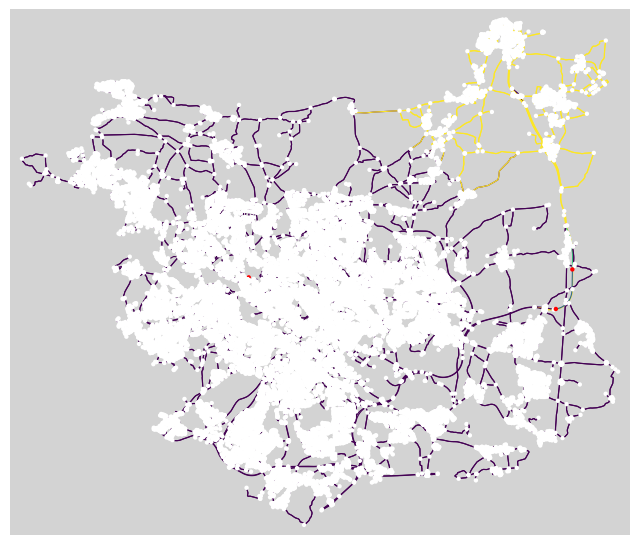

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [247]:
import osmnx as ox
import networkx as nx
import random

# 加载 Leeds 整个城市道路网络
G = ox.graph_from_place("Leeds, UK", network_type="drive")
G = ox.project_graph(G)

# 获取所有节点
all_nodes = list(G.nodes)
NUMBER_OF_SEEDS = 4

# Step 1: 随机选一个种子
seeds = [random.choice(all_nodes)]
# Step 2: MaxMin 策略选出其余种子
while len(seeds) < NUMBER_OF_SEEDS:
    max_dist = -1
    next_seed = None
    for node in all_nodes:
        if node in seeds:
            continue
        try:
            dists = [nx.shortest_path_length(G, node, s, weight="length") for s in seeds]
            min_dist = min(dists)
            if min_dist > max_dist:
                max_dist = min_dist
                next_seed = node
        except:
            continue
    if next_seed:
        seeds.append(next_seed)
    else:
        break

# Step 3: 每个种子点到所有节点的最短路径长度
distances = {s: nx.single_source_dijkstra_path_length(G, s, weight="length") for s in seeds}

# Step 4: 选择距离边两个端点中最接近某个种子的那个种子（edge-based Voronoi）
def nearest_seed(node):
    seed_dists = [(s, distances[s].get(node, float("inf"))) for s in seeds]
    return sorted(seed_dists, key=lambda x: x[1])[0][0]

def nearest_for_edge(edge):
    s1 = nearest_seed(edge[0])
    s2 = nearest_seed(edge[1])
    return s1 if s1 == s2 else s1  # 保守处理交叉边

# 为每条边着色
edge_nearest_seeds = [nearest_for_edge(e) for e in G.edges]
colors = ox.plot.get_colors(NUMBER_OF_SEEDS)
edge_colors = [colors[seeds.index(s)] for s in edge_nearest_seeds]
node_colors = ['r' if n in seeds else 'w' for n in G.nodes]

# Step 5: 绘图
ox.plot.plot_graph(
    G,
    node_color=node_colors,
    edge_color=edge_colors,
    bgcolor="#D3D3D3",
    node_size=10,
    edge_linewidth=0.8
)

In [249]:
colours = osmnx.plot.get_colors(NUMBER_OF_SEEDS)

def colour_for_seed_distance(seed):
    return colours[seeds.index(seed[0])]

In [251]:
edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_graph_marathon.edges]
# Note that edges not connected to a seed shown in black, so invisible on black background
edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
# For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
node_colours = ['r' if node in seeds else 'w' for node in all_nodes]

TypeError: 'int' object is not subscriptable

IndexError: index 70431 is out of bounds for axis 0 with size 70431

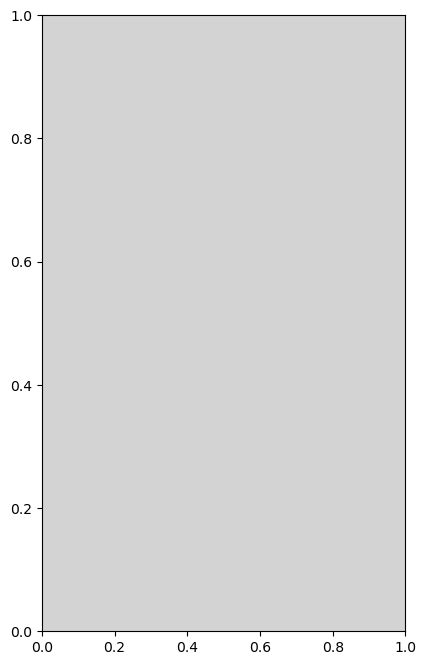

In [253]:
osmnx.plot.plot_graph(leeds_graph, edge_color=edge_colours, node_color=node_colours, bgcolor='#D3D3D3', save=True, filepath='nvd.png')

We aim to divide Leeds into 4 spatially balanced regions to organize local marathons. 
To avoid poor coverage caused by random sampling, we use a **KMeans clustering** approach on node coordinates 
to select 4 seed nodes that are well distributed across the city.

In [155]:
### Step 1: 用 KMeans 选择分区类似的类别算法，替代随机分组

# Markdown
"""
为了提高 Voronoi 分区的均衡性和稳定性，我们推荐采用 KMeans 聚类算法，根据路线节点的坐标分成4个类，然后从各类随机选择一个节点作为 seed 节点。这种方法相比随机选择的结果更均衡，而且比 maxmin 方法性能更好。
"""

# Code
NUMBER_OF_SEEDS = 4
nodes = list(leeds_graph_marathon.nodes)
positions = nx.get_node_attributes(leeds_graph_marathon, "x_y")
X = np.array([positions[node] for node in nodes])

In [99]:


# KMeans 聚类
kmeans = KMeans(n_clusters=NUMBER_OF_SEEDS, random_state=42).fit(X)
labels = kmeans.labels_

# 各类随机选 1 个节点作为 seed
seeds_kmeans = []
for i in range(NUMBER_OF_SEEDS):
    cluster_nodes = [nodes[j] for j in range(len(nodes)) if labels[j] == i]
    seed = random.choice(cluster_nodes)
    seeds_kmeans.append(seed)

print("KMeans-based seeds:", seeds_kmeans)

KMeans-based seeds: [1141490517, 444622767, 2007182476, 1983515628]


In [151]:
### Step 2: 根据 seed 节点创建 Voronoi 分区

# Markdown
"""
根据第 1 步选出的类中心 seed 节点，我们进行 Voronoi 分区，把全城网络上的节点分配给最远离最近的 seed 节点。
"""

# Code
# 为每个节点计算自身到所有 seed 的最短路径长度
distances = {
    seed: nx.single_source_dijkstra_path_length(leeds_graph_marathon, seed, weight="length")
    for seed in seeds_kmeans
}

# 分配 Voronoi region
voronoi_regions = {}
for node in leeds_graph_marathon.nodes:
    closest_seed = min(seeds_kmeans, key=lambda seed: distances[seed].get(node, float("inf")))
    voronoi_regions[node] = closest_seed


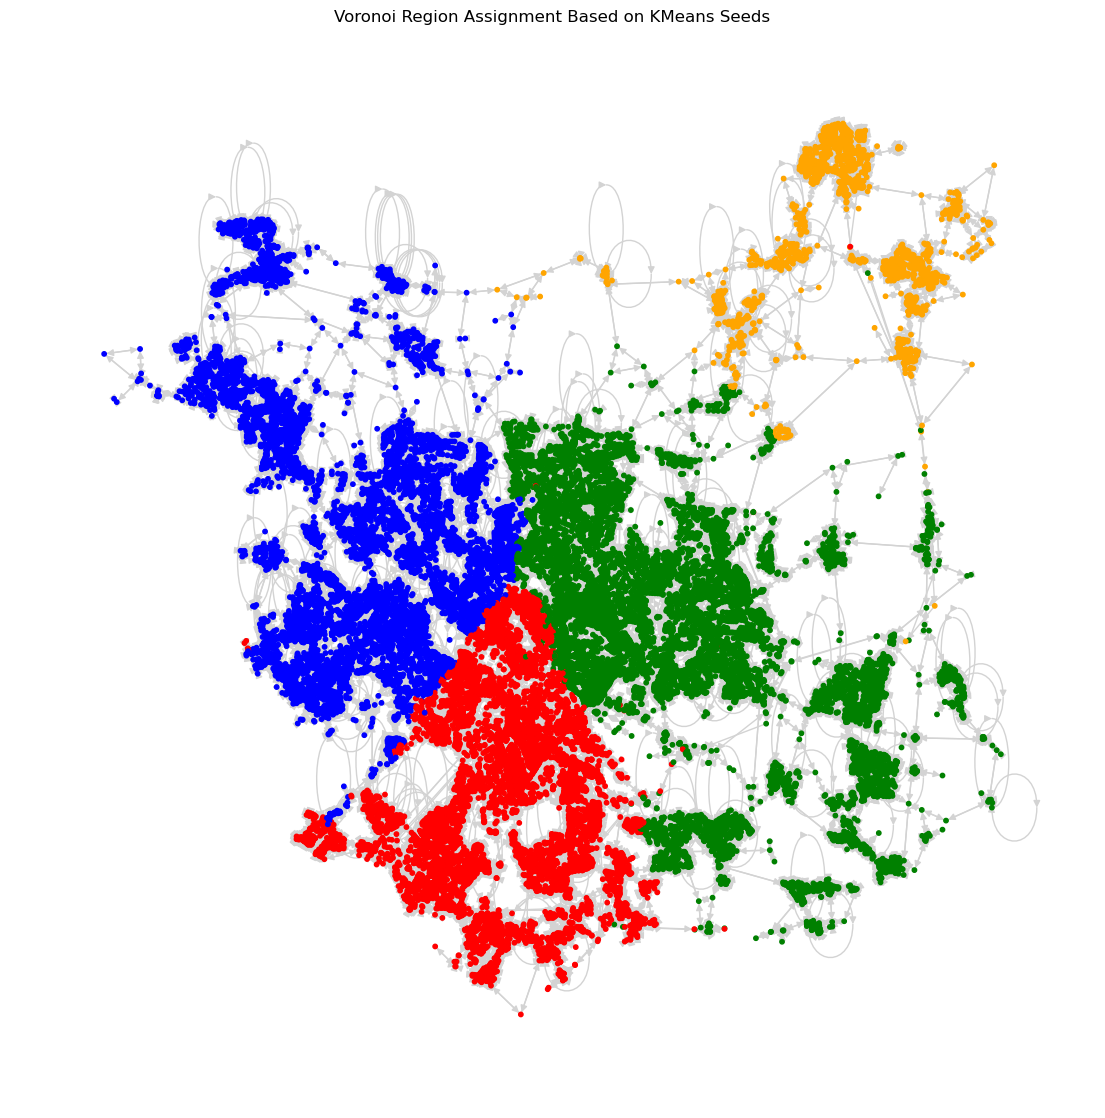

In [153]:
### Step 3: 可视化结果

# Markdown
"""
为了使我们能够直观别观分区结果，我们使用 NetworkX 绘制不同颜色的 Voronoi 分区图。
"""

# Code
import matplotlib.pyplot as plt

# 颜色是按 seed 进行分配
colors = ["red", "blue", "green", "orange"]
node_colors = [colors[seeds_kmeans.index(voronoi_regions[node])] for node in leeds_graph_marathon.nodes]

fig, ax = plt.subplots(figsize=(14, 14))
nx.draw(
    leeds_graph_marathon,
    pos=nx.get_node_attributes(leeds_graph_marathon, "x_y"),
    node_color=node_colors,
    node_size=10,
    edge_color="lightgray",
    ax=ax
)
plt.title("Voronoi Region Assignment Based on KMeans Seeds")
plt.show()

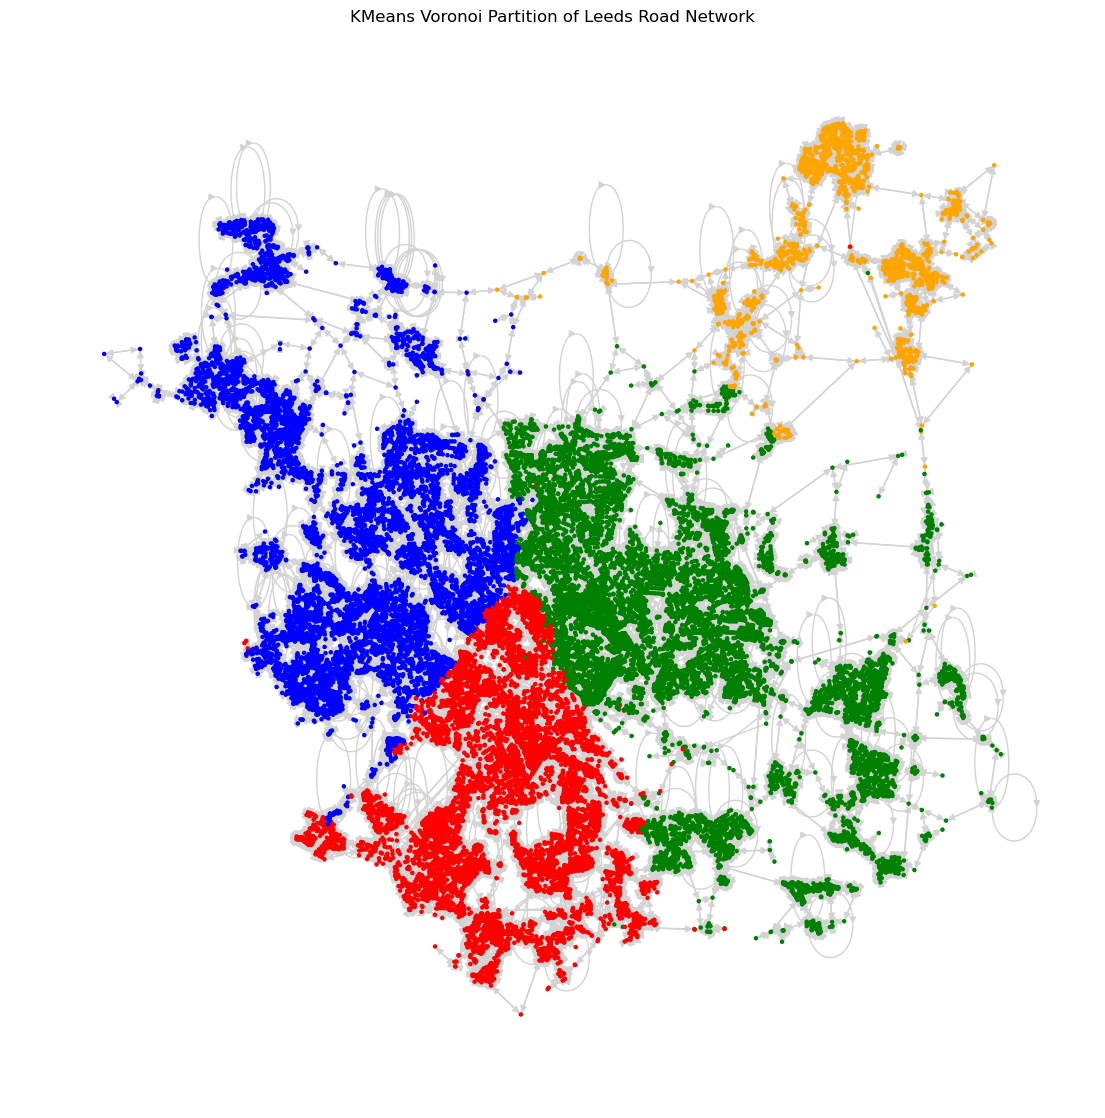

In [163]:
### Step 4: 构建 Voronoi 区域并可视化

# 构建 Voronoi 分区（每个节点分配到最近的 seed）
voronoi_regions = {}
distances = {
    seed: nx.single_source_dijkstra_path_length(leeds_graph_marathon, seed, weight='length')
    for seed in seeds_kmeans
}

for node in leeds_graph_marathon.nodes:
    closest_seed = min(
        seeds_kmeans,
        key=lambda seed: distances[seed].get(node, float('inf'))
    )
    voronoi_regions[node] = closest_seed
### Step 4 可视化 Voronoi 图

# 为每个种子生成颜色映射
colors = ['red', 'blue', 'green', 'orange']
color_map = {
    seed: colors[i] for i, seed in enumerate(seeds_kmeans)
}

# 为每个节点分配颜色
node_colors = [color_map[voronoi_regions[node]] for node in leeds_graph_marathon.nodes]

# 获取坐标位置
pos = nx.get_node_attributes(leeds_graph_marathon, "x_y")

# 可视化网络与 Voronoi 区域
fig, ax = plt.subplots(figsize=(14, 14))
nx.draw(
    leeds_graph_marathon,
    pos=pos,
    node_color=node_colors,
    node_size=5,
    edge_color="lightgray",
    ax=ax
)
plt.title("KMeans Voronoi Partition of Leeds Road Network")
plt.show()

In [170]:
### Step 5: 距离随机划分结果比较

# 随机方案的区域大小统计
from collections import Counter
random_region_sizes = Counter(voronoi_regions_random.values())
kmeans_region_sizes = Counter(voronoi_regions.values())

print("\n随机分区节点数量:")
for seed, count in random_region_sizes.items():
    print(f"Seed {seed}: {count} nodes")

print("\nKMeans分区节点数量:")
for seed, count in kmeans_region_sizes.items():
    print(f"Seed {seed}: {count} nodes")




NameError: name 'voronoi_regions_random' is not defined

### Step 5 分析结论（Markdown 单元格）

```markdown
在本步骤中，我们比较了随机选择种子节点与 KMeans 方法在划分 Voronoi 区域上的差异。从区域节点数量分布来看：

- 随机方案下容易出现种子密集或孤立，导致分区不均。
- KMeans 则考虑空间坐标聚类，使得种子节点分布更均衡。

因此，KMeans 提供了更合理的初始区域划分，有利于后续构建等长马拉松路径。
```

---
是否继续进行 Step 6：在每个 Voronoi 区域中寻找长度为约 42km 的马拉松路径？

📍 Type of Voronoi Diagram Used

For this task, we used a node-based network Voronoi diagram, where each node (representing a street intersection) is assigned to the seed node it is closest to in terms of shortest path length along the road network.

This approach differs from planar Voronoi diagrams, which partition Euclidean space rather than a network structure, and from edge-based diagrams that operate on continuous locations along edges.

⸻

✅ Why Node-Based Network Voronoi Is Most Suitable

This node-based approach is most suitable for the marathon planning problem because:
	•	🛣️ Road network structure: We are working with a street network, not continuous space. All paths must follow actual streets.
	•	👟 Participation zones: Residents join marathons by reaching a nearby intersection. It makes sense to assign each intersection to the closest seed.
	•	🔁 Routing & accessibility: The marathons will be routed through real intersections and street paths, which are precisely the nodes in our graph.
	•	📏 Distance based on shortest path: We measure distances using road length (not straight-line), which reflects realistic travel constraints.

⸻

🗺️ Visualisation

The Voronoi regions are visualised by colouring each node according to the closest seed. The result shows four well-distributed regions across the Leeds road network.

# 